<a href="https://colab.research.google.com/github/Lolo-17/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/Logistic_Regression_LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

# Wrangle Data

## Import

In [260]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [261]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv',
                 parse_dates=['Date'],
                 index_col='Date')
df = df.sort_values(by='Date')

In [262]:
# Libraries.
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split

# For pipeline.
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

# To predict.
from sklearn.metrics import accuracy_score

## EDA

In [263]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [264]:
# Clean/combine the Burrito categories.
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [265]:
# Drop some high cardinality categoricals.
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [266]:
# Drop some columns to prevent "leakage".
df = df.drop(columns=['Rec', 'overall'])

In [267]:
# Looking at shape and first 5 rows of dataframe.
print(df.shape)
df.head()

(421, 58)


,Burrito,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-05-16,Other,NaN,NaN,NaN,8.00,4.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,2.0,3.0,2.0,3.0,2.0,3.0,2.0,x,NaN,x,x,x,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2015-04-20,Other,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,5.0,5.0,5.0,4.0,5.0,5.0,5.0,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2016-01-18,California,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-24,Asada,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2016-01-24,Carnitas,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [268]:
# Showing all kinds of information for dataframe.
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421 entries, 2011-05-16 to 2026-04-25
Data columns (total 58 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Burrito         421 non-null    object 
 1   Yelp            87 non-null     float64
 2   Google          87 non-null     float64
 3   Chips           26 non-null     object 
 4   Cost            414 non-null    float64
 5   Hunger          418 non-null    float64
 6   Mass (g)        22 non-null     float64
 7   Density (g/mL)  22 non-null     float64
 8   Length          283 non-null    float64
 9   Circum          281 non-null    float64
 10  Volume          281 non-null    float64
 11  Tortilla        421 non-null    float64
 12  Temp            401 non-null    float64
 13  Meat            407 non-null    float64
 14  Fillings        418 non-null    float64
 15  Meat:filling    412 non-null    float64
 16  Uniformity      419 non-null    float64
 17  Salsa           

In [269]:
# To see earliest and lastest date.
df.index

DatetimeIndex(['2011-05-16', '2015-04-20', '2016-01-18', '2016-01-24',
               '2016-01-24', '2016-01-24', '2016-01-27', '2016-01-28',
               '2016-01-30', '2016-01-30',
               ...
               '2019-08-27', '2019-08-27', '2019-08-27', '2019-08-27',
               '2019-08-27', '2019-08-27', '2019-08-27', '2019-08-27',
               '2019-08-27', '2026-04-25'],
              dtype='datetime64[ns]', name='Date', length=421, freq=None)

In [270]:
# To copy columns and to drop some.
df.columns

Index(['Burrito', 'Yelp', 'Google', 'Chips', 'Cost', 'Hunger', 'Mass (g)',
       'Density (g/mL)', 'Length', 'Circum', 'Volume', 'Tortilla', 'Temp',
       'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy',
       'Wrap', 'Unreliable', 'NonSD', 'Beef', 'Pico', 'Guac', 'Cheese',
       'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish', 'Rice',
       'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots', 'Cabbage',
       'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito', 'Pineapple', 'Ham',
       'Chile relleno', 'Nopales', 'Lobster', 'Queso', 'Egg', 'Mushroom',
       'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini', 'Great'],
      dtype='object')

In [271]:
# Replacing bools values in [Great] for 1 and 0.
df.Great = df.Great.replace([False, True], [0,1])

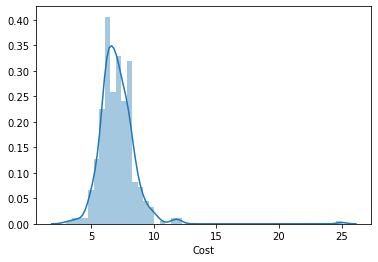

In [272]:
sns.distplot(df['Cost']);

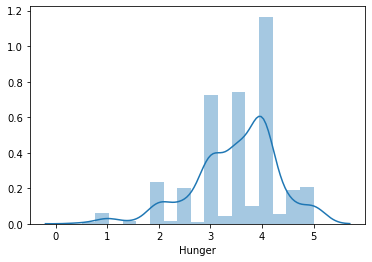

In [273]:
sns.distplot(df['Hunger']);

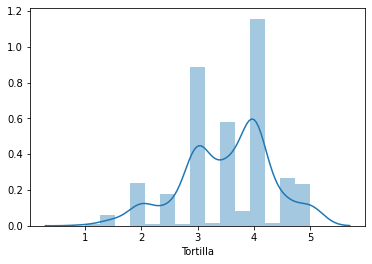

In [274]:
sns.distplot(df['Tortilla']);

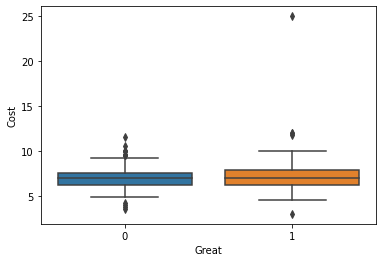

In [275]:
sns.boxplot(x='Great', y='Cost', data=df);

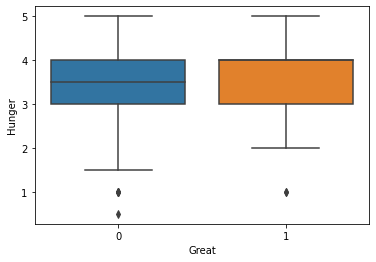

In [276]:
sns.boxplot(x='Great', y='Hunger', data=df);

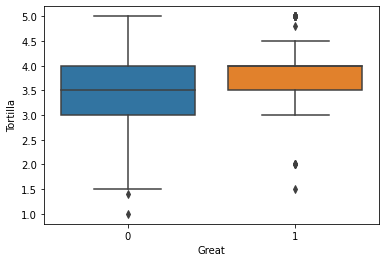

In [277]:
sns.boxplot(x='Great', y='Tortilla', data=df);

# Split Data

In [278]:
not_needed = ['Chips', 'Cost', 'Hunger', 'Mass (g)',
       'Density (g/mL)', 'Length', 'Circum', 'Volume', 'Tortilla', 'Temp',
       'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy',
       'Wrap', 'Unreliable', 'NonSD', 'Beef', 'Pico', 'Guac', 'Cheese',
       'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish', 'Rice',
       'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots', 'Cabbage',
       'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito', 'Pineapple', 'Ham',
       'Chile relleno', 'Nopales', 'Lobster', 'Queso', 'Egg', 'Mushroom',
       'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini']

# My target is Great.
target = 'Great'
y = df[target]
X = df.drop([target]+not_needed, axis=1)

# Training 2016 data.
# Validating 2017 data.
# Testing 2018 data.
D16 = X.index < '2017'
D17 = (X.index > '2017') & (X.index < '2018')
D18 = X.index > '2018'
X_train, y_train = X.loc[D16], y.loc[D16]
X_val, y_val = X.loc[D17], y.loc[D17]
X_test, y_test = X.loc[D18], y.loc[D18]

# Establish the Baseline

In [279]:
# Displaying min value of y train by minority class.
print('Low accuracy:', y_train.value_counts(normalize=True).min())

Low accuracy: 0.40939597315436244


In [280]:
# Baseline accuracy is determined by the MAJORITY CLASS.
print('Baseline accuracy:', y_train.value_counts(normalize=True).max())

Baseline accuracy: 0.5906040268456376


# Create the Model

In [281]:
# Step 1.) Instantiate our pipeline
model = make_pipeline(
    OneHotEncoder(use_cat_names=True, cols=['Burrito', 'Yelp', 'Google']),
    SimpleImputer(missing_values=np.nan, strategy='mean'),
    LogisticRegression()
    )

# Step 2.) Fit our model to the training data
model.fit(X_train, y_train);

In [282]:
# model = make_pipeline(
#     OneHotEncoder(),
#     SimpleImputer(),
#     LogisticRegression()
#     )

# model.fit(X_train, y_train);

# Check Metrics

In [283]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))
print('Test Accuracy:', model.score(X_test, y_test))

Training Accuracy: 0.6375838926174496
Validation Accuracy: 0.6
Test Accuracy: 0.39473684210526316


In [284]:
# Step 3.) Predict
y_pred = model.predict(X_val)
print('2017 predict:', accuracy_score(y_val, y_pred))
y_pred_18 = model.predict(X_test)
print('2018 predict:', accuracy_score(y_test, y_pred_18))

2017 predict: 0.6
2018 predict: 0.39473684210526316


# Probabilities

In [285]:
y_pred_proba = model.predict_proba(X_val)

In [286]:
y_pred_proba.shape

(85, 2)

In [287]:
y_pred[10:20]

array([0, 0, 0, 1, 1, 1, 1, 0, 0, 0])

In [288]:
y_pred_proba[10:20]

array([[0.62152568, 0.37847432],
       [0.62152568, 0.37847432],
       [0.62152568, 0.37847432],
       [0.44374464, 0.55625536],
       [0.44374464, 0.55625536],
       [0.44374464, 0.55625536],
       [0.4976736 , 0.5023264 ],
       [0.62152568, 0.37847432],
       [0.62152568, 0.37847432],
       [0.62152568, 0.37847432]])

# With `train_test_split`

In [289]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.42, random_state=17)

In [290]:
# model = make_pipeline(
#     OneHotEncoder(),
#     SimpleImputer(),
#     LogisticRegression()
#     )

# model.fit(X_train, y_train);

In [291]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True, cols=['Burrito', 'Yelp', 'Google']),
    SimpleImputer(missing_values=np.nan, strategy='mean'),
    LogisticRegression()
    )

model.fit(X_train, y_train);

In [292]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))
print('Test Accuracy:', model.score(X_test, y_test))

Training Accuracy: 0.6557377049180327
Validation Accuracy: 0.5480225988700564
Test Accuracy: 0.5


In [293]:
y_pred = model.predict(X_val)
print('2017 predict:', accuracy_score(y_val, y_pred))
y_pred_18 = model.predict(X_test)
print('2018 predict:', accuracy_score(y_test, y_pred_18))

2017 predict: 0.5480225988700564
2018 predict: 0.5


In [294]:
y_pred_proba = model.predict_proba(X_val)

In [295]:
y_pred[10:20]

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 1])

In [296]:
y_pred_proba[10:20]

array([[0.59503882, 0.40496118],
       [0.55237667, 0.44762333],
       [0.39506621, 0.60493379],
       [0.37800343, 0.62199657],
       [0.59503882, 0.40496118],
       [0.79968339, 0.20031661],
       [0.59503882, 0.40496118],
       [0.60857564, 0.39142436],
       [0.90714008, 0.09285992],
       [0.39506621, 0.60493379]])